In [1]:
%load_ext autoreload
%autoreload 2
from dpe import DPE
from lib_data import *
import matplotlib.pyplot as plt
import numpy as np
from lib_nn_dpe import NN_dpe
from IPython import display

load_workspace(vars(), 'dataset/20190815-132601-weights')
load_workspace(vars(), 'dataset/mnist')

Loaded: weights, 
Loaded: train_images, train_labels, test_images, test_labels, 


In [2]:
dpe = DPE('COM3')

Running <function DPE.init_dut at 0x000002494F056048> with serial
DAC initialized to a span from -10 V to 10 V
Setting vrefs to default
[INFO] Elapsed time = 0.03s
Serial disconnected


In [3]:
dpe.set_clock(50)

Running <function DPE.set_clock at 0x000002494F056168> with serial
Setting ADC_CK freq=50000.0kHz
Setting CK_ARRAY freq=50000.0kHz
[INFO] Elapsed time = 0.00s
Serial disconnected


In [4]:
g = dpe.read(0)

Running <function DPE.read at 0x000002494F056288> with serial
[INFO] Elapsed time = 0.25s
Serial disconnected


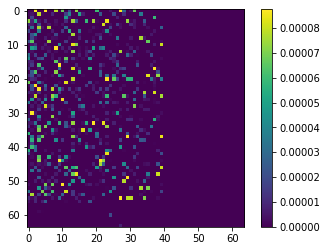

In [5]:
plt.imshow(g)
# plt.clim(0, 2e-4)
plt.colorbar()

In [8]:
nn = NN_dpe(weights)

In [1]:
img_idx = 6

image = test_images[img_idx]
vectors = nn._conv_flattern(image)
vectors.max()

NameError: name 'test_images' is not defined

In [8]:
outputs = dpe.multiply(1, vectors, c_sel=[0, 14]) / (nn.Gratio/2) / 0.2

Running <function DPE.multiply at 0x000001D6D15534C8> with serial
[INFO] Elapsed time = 1.54s
Serial disconnected


In [17]:
outputs.shape

(400, 14)

In [20]:
software = (finalGconv.T @ vectors).T / (nn.Gratio/2)

In [ ]:
for c in range(14):
    x = []
    y = []
        
    plt.figure(c+1)
    plt.title(f'Column {c}')
    plt.plot(outputs[:,c],software[:,c], '.', alpha=0.3)
    plt.xlabel('Expectation')

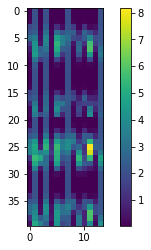

In [22]:
plt.imshow(software[:40])
plt.colorbar()

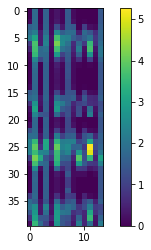

In [23]:
plt.imshow(outputs[:40])
plt.colorbar()

In [28]:
linear_factors_conv = []
for c in range(14):
    linear_factors_conv.append( np.polyfit(outputs[:,c], software[:,c], 1))
    
linear_factors_conv = np.array(linear_factors_conv)
linear_factors_conv

array([[ 1.10600809,  0.02558262],
       [ 1.0400355 ,  0.85863644],
       [ 1.30230276,  0.00215507],
       [ 1.44122246, -0.16235268],
       [ 1.23063979, -0.09618758],
       [ 1.08255167,  0.03345652],
       [ 1.10381478, -0.07628634],
       [ 1.23586714,  0.08344223],
       [ 1.06021022, -0.08062452],
       [ 1.37758174, -0.16723768],
       [ 1.17893294,  0.0187636 ],
       [ 1.12354446,  0.03942665],
       [ 1.22563643,  0.01260009],
       [ 0.79969926,  0.41632605]])

In [9]:
for c in range(outputs.shape[1]):
    outputs[:,c] = outputs[:,c] * linear_factors_conv[c][0] + linear_factors_conv[c][1]

In [31]:
result = outputs[:, ::2] - outputs[:,1::2]
x = result.reshape(20,20,-1)
# for i in range(7):
#     plt.figure(i)
#     plt.imshow(x[:,:,i])
#     plt.colorbar()

In [32]:
x1 = nn.relu(x)
x1 = nn.max_pooling(x1)
x1 = nn.flattern(x1)
y = nn.dense(x1)

print('predicted', y.argmax())
print('label', test_labels[img_idx])

predicted 4
label 4


In [ ]:
xs = []
acc = []

for img_idx in range(len(test_images)):
    
    
    image = test_images[img_idx]
    vectors = nn._conv_flattern(image)
    
    outputs = dpe.multiply(1, vectors, c_sel=[0, 14]) / (nn.Gratio/2) / 0.2
    
    for c in range(outputs.shape[1]):
        outputs[:,c] = outputs[:,c] * linear_factors_conv[c][0] + linear_factors_conv[c][1]
    
    result = outputs[:, ::2] - outputs[:,1::2]
    x = result.reshape(20,20,-1)
    
    x1 = nn.relu(x)
    x1 = nn.max_pooling(x1)
    x1 = nn.flattern(x1)
    
    xs.append(x1)
    y = nn.dense(x1)
    
    display.clear_output(wait=True)

    print(f'idx={img_idx}, predicted: {y.argmax()}, label: {test_labels[img_idx]}')
    acc.append( y.argmax() == test_labels[img_idx] )
    print(f'\t Accuracy = {np.mean(acc)*100:.2f}%')
    
save_workspace(vars(), note='mnist_xs')

In [6]:
load_workspace(vars(), 'dataset/20190821-051552-mnist_xs')

# load_workspace(vars(), 'mnist_xs_software')
xs = np.array(xs)

Loaded: In, Out, weights, train_images, train_labels, test_images, test_labels, g, img_idx, image, vectors, outputs, software, c, x, y, mat_contents, finalGconv, g1, g2, linear_factors_conv, xs, acc, result, x1, 


In [9]:
# Check xs 
acc = []

for img_idx in range(len(test_images)):
    x1 = xs[img_idx]
    y = nn.dense(x1)
    
    if (img_idx+1)%100 == 0:
        display.clear_output(wait=True)

        print(f'idx={img_idx}, predicted: {y.argmax()}, label: {test_labels[img_idx]}')
        acc.append( y.argmax() == test_labels[img_idx] )
        print(f'\t Accuracy = {np.mean(acc)*100:.2f}%')

idx=9999, predicted: 6, label: 6
	 Accuracy = 98.00%


In [10]:
xs

array([[ 1.43760178, -0.        ,  2.6677077 , ..., -0.        ,
        -0.        , -0.        ],
       [ 0.40300978,  0.68757231,  2.79176243, ..., -0.        ,
         3.54113916,  2.61077068],
       [-0.        , -0.        ,  0.06726302, ..., -0.        ,
        -0.        , -0.        ],
       ...,
       [-0.        , -0.        ,  0.11108644, ..., -0.        ,
        -0.        , -0.        ],
       [-0.        , -0.        ,  0.11126897, ..., -0.        ,
        -0.        , -0.        ],
       [-0.        , -0.        ,  0.79958419, ..., -0.        ,
         3.2943451 ,  1.30286908]])

In [11]:
xs = np.array(xs)
xs.shape

(10000, 112)

In [12]:
xs = np.concatenate((xs, np.ones((xs.shape[0], 1))), axis=1)

In [13]:
xs.shape

(10000, 113)

Running <function DPE.read at 0x000002494F056288> with serial
[INFO] Elapsed time = 0.25s
Serial disconnected


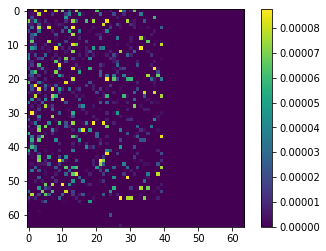

In [14]:
plt.imshow(dpe.read(0))
plt.colorbar()

In [15]:
import scipy.io as sio
mat_contents = sio.loadmat('UpdatedGfc.mat')
finalGfc = mat_contents['finalGfc']

In [197]:
x = xs[0:400]

x1 = x[:,:57].T
x2 = x[:,57:].T

sc1 = x1.max()
sc2 = x2.max()

Gfc1 = finalGfc[:57]
Gfc2 = finalGfc[57:]

x1 = x1 / sc1
x2 = x2 / sc2

In [244]:
dpe.N_BIT = 8

output1 = dpe.multiply_w_delay(0, x1, c_sel=[0, 20], mode=0, delay=1, debug=False)
software1 = (Gfc1.T @ x1).T 

output2 = dpe.multiply_w_delay(0, x2, c_sel=[20, 40], mode=0, delay=1, debug=False)
software2 = (Gfc2.T @ x2).T 

Running <function DPE.multiply_w_delay at 0x000002494F056828> with serial
[INFO] Elapsed time = 5.55s
Serial disconnected
Running <function DPE.multiply_w_delay at 0x000002494F056828> with serial
[INFO] Elapsed time = 5.63s
Serial disconnected


In [245]:
# dpe.N_BIT = 64

# output1 = dpe.multiply(0, x1, c_sel=[0, 20], mode=1)
# software1 = (Gfc1.T @ x1).T 

# output2 = dpe.multiply(0, x2, c_sel=[20, 40], mode=1)
# software2 = (Gfc2.T @ x2).T 

In [246]:
output1.shape

(400, 20)

In [247]:
# output1 = dpe.multiply(0, x1, c_sel=[0, 20])
# software1 = (Gfc1.T @ x1).T 

# output2 = dpe.multiply(0, x2, c_sel=[20, 40])
# software2 = (Gfc2.T @ x2).T 

In [248]:
lin_cor_fc1 = []
lin_cor_fc2 = []
for c in range(20):
    lin_cor_fc1.append( np.polyfit(output1[:,c], software1[:,c], 1))
    lin_cor_fc2.append( np.polyfit(output2[:,c], software2[:,c], 1))

In [249]:
np.array(lin_cor_fc2)

array([[ 1.25800751e+00, -2.06407758e-05],
       [ 1.23959541e+00,  1.50813304e-05],
       [ 1.14393009e+00, -4.75903706e-06],
       [ 1.19389208e+00, -4.00545485e-06],
       [ 1.22324468e+00, -4.78056683e-06],
       [ 1.36200552e+00,  5.75107629e-07],
       [ 1.45961155e+00, -1.13385651e-05],
       [ 1.12938593e+00,  3.17705723e-05],
       [ 1.43583243e+00, -1.63008769e-05],
       [ 1.32517612e+00,  6.64388793e-06],
       [ 1.41560015e+00, -3.87320957e-06],
       [ 1.29130484e+00,  8.98386868e-06],
       [ 1.23109186e+00, -1.78141593e-06],
       [ 1.07737838e+00,  2.30865156e-05],
       [ 1.29197652e+00,  1.74728303e-05],
       [ 1.11241845e+00,  2.72542587e-05],
       [ 1.29961787e+00, -9.38769459e-06],
       [ 9.64649447e-01,  2.67560316e-05],
       [ 1.08327699e+00,  1.54020075e-05],
       [ 1.22556419e+00, -1.07231965e-05]])

In [250]:
def lin_corr(outputs, factors):
    result = np.zeros(outputs.shape)
    for c in range(outputs.shape[1]):
        result[:,c] = outputs[:,c] * factors[c][0] + factors[c][1]
        
    return result

In [251]:
output_corr = lin_corr(output2, lin_cor_fc2)
software = (Gfc2.T @ x2).T 

In [262]:
%config InlineBackend.figure_formats = ['svg']
import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial"

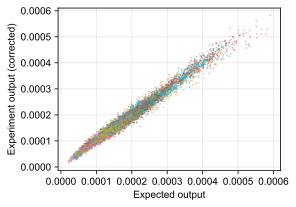

In [267]:
plt.figure(figsize=(4,3))
plt.grid(True, alpha=0.3)
plt.xlabel('Expected output')
plt.ylabel('Experiment output (corrected)')

for c in range(20):
    x = software[:,c]
    y = output_corr[:,c]
    
#     plt.figure(c)
    plt.plot(x,y,'.', alpha=0.5, markersize=1)

#     lin_cor_fc2.append( np.polyfit(y, x, 1))

# plt.savefig('20190822-unary64-error.eps')

Text(0.5, 1.0, 'Standard deviation = 2.29%')

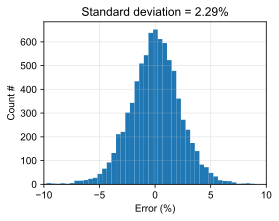

In [273]:
plt.figure(figsize=(4,3))
plt.grid(True, alpha=0.3)

_ = plt.hist((output_corr-software).reshape(-1, 1)/0.0006 * 100, bins=50 )

plt.xlim(-10, 10)
plt.xlabel('Error (%)')
plt.ylabel('Count #')

plt.title('Standard deviation = 2.29%')

# plt.savefig('20190822-unary64-hist.eps')

In [272]:
(output_corr-software).reshape(-1, 1).std()/0.0006

0.022912457096816222

In [255]:
# load_workspace(vars(), '20190821-051552-mnist_xs')
# xs = np.array(xs)

In [259]:
ys = []
batch_size = 100

for i in range( (len(test_images)-1)//batch_size + 1 ):
    idx1 = i * batch_size
    idx2 = (i+1) * batch_size
    idx2 = idx2 if idx2<= len(test_images) else len(test_images)
    
    print(f'Running on sample {idx1}-{idx2}')

    x = xs[idx1:idx2]

    x1 = x[:,:57].T
    x2 = x[:,57:].T

    sc1 = x1.max()
    sc2 = x2.max()

    Gfc1 = nn.Gfc[:57]
    Gfc2 = nn.Gfc[57:]

    x1 = x1 / sc1
    x2 = x2 / sc2
    
    output1  = dpe.multiply_w_delay(0, x1, c_sel=[0, 20], mode=0, debug=True, delay=1)
    output1 = lin_corr(output1, lin_cor_fc1) * sc1

    output2  = dpe.multiply_w_delay(0, x2, c_sel=[20, 40], mode=0, debug=True, delay=1)
    output2 = lin_corr(output2, lin_cor_fc2) * sc2

    outputs = output1 + output2
    
    y = outputs[:,::2] - outputs[:,1::2]
    
    display.clear_output(wait=True)
    
    print(f'Batch accuracy = {np.mean(y.argmax(axis=1) == test_labels[idx1:idx2])*100:.2f}%')
    ys.append(y)
    print(f'Overall accuracy = {np.mean(np.concatenate(ys).argmax(axis=1) == test_labels[:idx2])*100:.2f}%')
    
ys = np.concatenate(ys)  

Batch accuracy = 96.00%
Overall accuracy = 95.33%


In [260]:
np.mean(ys.argmax(axis=1) == test_labels)

0.9533

In [234]:
# load_workspace(vars(), '20190822-090423-prober2-modFC-delay-unary-64bit')

Loaded: In, Out, weights, train_images, train_labels, test_images, test_labels, g, img_idx, image, vectors, outputs, software, c, x, y, mat_contents, finalGconv, g1, g2, linear_factors_conv, xs, acc, result, x1, finalGfc, x2, sc1, sc2, Gfc1, Gfc2, output1, software1, output2, software2, lin_cor_fc1, lin_cor_fc2, output_corr, ys, batch_size, i, idx1, idx2, 


In [261]:
save_workspace(vars(), note='prober2-reprogFC-delay-shift_add-8bit-95.33')

Saving In(<class 'list'>), Out(<class 'dict'>), weights(<class 'numpy.ndarray'>), train_images(<class 'numpy.ndarray'>), train_labels(<class 'numpy.ndarray'>), test_images(<class 'numpy.ndarray'>), test_labels(<class 'numpy.ndarray'>), g(<class 'numpy.ndarray'>), img_idx(<class 'int'>), image(<class 'numpy.ndarray'>), vectors(<class 'numpy.ndarray'>), outputs(<class 'numpy.ndarray'>), software(<class 'numpy.ndarray'>), c(<class 'int'>), x(<class 'numpy.ndarray'>), y(<class 'numpy.ndarray'>), mat_contents(<class 'dict'>), finalGconv(<class 'numpy.ndarray'>), g1(<class 'numpy.ndarray'>), g2(<class 'numpy.ndarray'>), linear_factors_conv(<class 'numpy.ndarray'>), xs(<class 'numpy.ndarray'>), acc(<class 'list'>), result(<class 'numpy.ndarray'>), x1(<class 'numpy.ndarray'>), finalGfc(<class 'numpy.ndarray'>), x2(<class 'numpy.ndarray'>), sc1(<class 'numpy.float64'>), sc2(<class 'numpy.float64'>), Gfc1(<class 'numpy.ndarray'>), Gfc2(<class 'numpy.ndarray'>), output1(<class 'numpy.ndarray'>), 

In [29]:
ynew.argmax(axis=1) == test_labels

array([ True,  True, False, ...,  True,  True,  True])

In [19]:
import scipy.io as sio
#load_workspace(vars(), '20190814-205207-CNN weights')
mat_contents = sio.loadmat('UpdatedGconv.mat')
finalGconv = mat_contents['finalGconv']

(26, 14)

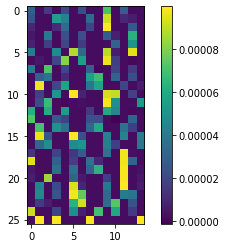

In [19]:
plt.imshow(finalGconv)
plt.colorbar()
np.shape(finalGconv)

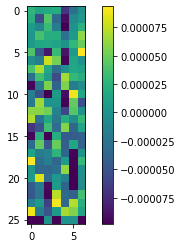

In [22]:
g1 = finalGconv[:,::2] - finalGconv[:,1::2]
plt.imshow(g1)
plt.colorbar()

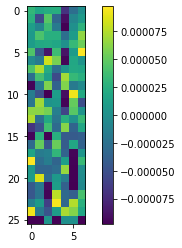

In [24]:
g2 = nn.Gconv[:,::2] - nn.Gconv[:,1::2]
plt.imshow(g2/2)
plt.colorbar()

(array([-5.0e-07,  0.0e+00,  5.0e-07,  1.0e-06,  1.5e-06,  2.0e-06,
         2.5e-06,  3.0e-06,  3.5e-06,  4.0e-06,  4.5e-06]),
 <a list of 11 Text xticklabel objects>)

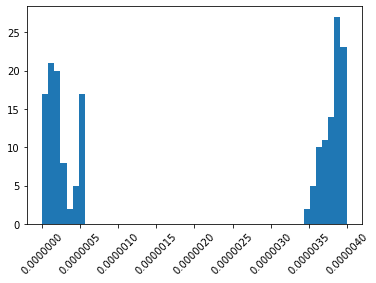

In [31]:
plt.hist((g2/2-g1).reshape(-1,1), bins=50)
plt.xticks(rotation=45)

In [4]:
import dut_func as dut
import serial
import time
import struct
import numpy as np
# from bitarray import bitarray
from bitstring import BitArray
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
import dut_a0 as a0

from misc import *
vOffset = -0.08
dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)

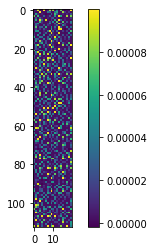

In [238]:
plt.imshow(finalGfc)
plt.colorbar()

In [245]:
g = dpe.read(0)

Running <function DPE.read at 0x000001C3A2159288> with serial
[INFO] Elapsed time = 0.25s
Serial disconnected


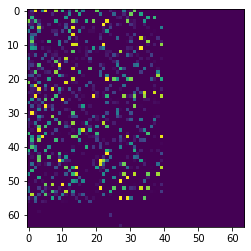

In [246]:
plt.imshow(g)

In [247]:
%reload_ext autoreload
%autoreload 2

import dut_func as dut
import serial
import time
import struct
import numpy as np
# from bitarray import bitarray
from bitstring import BitArray
import matplotlib.pyplot as plt
# %config InlineBackend.figure_formats = ['svg']
import dut_a0 as a0

from misc import *

# dut.drv.serUSB = 'COM19'
drv = dut.drv

ser = serial.Serial('COM3', 9600, timeout=1)
dut.connect(ser)

In [248]:
dut.reset_chip()
dut.reset_dpe()
dut.ground_PIC()
dut.power_on()

DAC initialized to a span from -10 V to 10 V
Setting vrefs to default


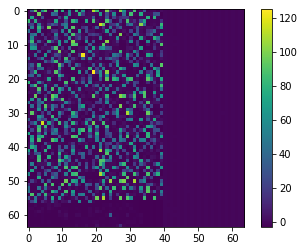

In [250]:
VADC_boundary = np.array([0.4, 1.692, 1.927, 2.247, 2.645, 3.045, 3.391, 3.688, 4.1])
VRefHiCmp = np.array([5.3, 4.5, 4.2, 3.8, 3.4, 3.0, 2.7, 2.4])

_gain_ratio = [
    1e3,
    5e3,
    30e3,
    200e3,
    1e6
]
Vgate = 5.0
vOffset = 0.00
dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)

arr = 0
numRows = 64
numCols = 64
vRead = 0.2
vReadGate = 5.0
gains = np.array([4, 3, 2, 1, 0])
maxCurr = np.array([3.2e-3, 650e-6, 110e-6, 14.0e-6, 3.3e-6])
Gmap0post = np.zeros((numRows, numCols))
for rr in range(numRows):
        for cc in range(numCols):
            adc_raw = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1, raw=True)
            VADC_read_first = dut.adc2volt(adc_raw)
            gainFirst = adc_raw >> 10
            secondVRefHiCmpIndex = np.searchsorted(VADC_boundary,VADC_read_first)-1
            secondVRefHiCmp = VRefHiCmp[secondVRefHiCmpIndex]+vOffset
            dut.dac_set('DAC_VREF_HI_CMP', secondVRefHiCmp+vOffset) 
            VADC_read_sec = dut.adc2volt(a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=gainFirst, raw=True))
            finalADCOut = VADC_read_sec - (secondVRefHiCmp - 4.0) 
            dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
            rdCurr = (finalADCOut - 0.5) / _gain_ratio[gainFirst]
        
            Gmap0post[rr,cc] = 1e6*rdCurr/vRead
plt.imshow(Gmap0post)
plt.colorbar()

In [253]:
from lib_data import *
import scipy.io as sio
mat_contents = sio.loadmat('UpdatedGfc.mat')
finalGfc = mat_contents['finalGfc']

GMin = 2e-6
GMax = 100e-6

scaledGfc = finalGfc

newGfc = np.zeros((57,40))+GMin
newGfc[0:57,0:20]=scaledGfc[0:57,0:20]
newGfc[0:56,20:40]=scaledGfc[57:113,0:20]

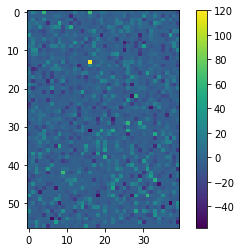

In [254]:
plt.imshow(Gmap0post[0:57,0:40]-1e6*newGfc)
plt.colorbar()

In [255]:
save_workspace(vars(), note='Prober2_newFC_results')

Saving In(<class 'list'>), Out(<class 'dict'>), weights(<class 'numpy.ndarray'>), train_images(<class 'numpy.ndarray'>), train_labels(<class 'numpy.ndarray'>), test_images(<class 'numpy.ndarray'>), test_labels(<class 'numpy.ndarray'>), g(<class 'numpy.ndarray'>), img_idx(<class 'int'>), image(<class 'numpy.ndarray'>), vectors(<class 'numpy.ndarray'>), outputs(<class 'numpy.ndarray'>), software(<class 'numpy.ndarray'>), c(<class 'int'>), x(<class 'numpy.ndarray'>), y(<class 'numpy.ndarray'>), mat_contents(<class 'dict'>), finalGconv(<class 'numpy.ndarray'>), g1(<class 'numpy.ndarray'>), g2(<class 'numpy.ndarray'>), linear_factors_conv(<class 'numpy.ndarray'>), xs(<class 'numpy.ndarray'>), acc(<class 'list'>), result(<class 'numpy.ndarray'>), x1(<class 'numpy.ndarray'>), finalGfc(<class 'numpy.ndarray'>), x2(<class 'numpy.ndarray'>), sc1(<class 'numpy.float64'>), sc2(<class 'numpy.float64'>), Gfc1(<class 'numpy.ndarray'>), Gfc2(<class 'numpy.ndarray'>), output1(<class 'numpy.ndarray'>), 

In [257]:
from lib_data import *
import scipy.io as sio
mat_contents = sio.loadmat('Prober2TargetDevices.mat')
targetRowsPython = mat_contents['targetRowsPython']
targetColsPython = mat_contents['targetColsPython']

In [261]:
np.size(targetRowsPython)
print(targetRowsPython)

[[ 0  0  0  0  0  0  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  3  3
   3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  5  5  5  5  6  6  6  6
   6  6  6  6  7  7  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  9  9
   9  9  9  9  9  9  9  9 10 10 10 10 10 10 10 10 11 11 11 11 12 12 13 13
  13 13 13 13 14 14 14 14 14 14 14 14 14 14 14 14 15 15 16 16 16 16 16 16
  16 16 16 16 17 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18 18 18 18 18
  18 18 18 18 18 18 19 19 19 19 19 19 20 20 20 20 20 20 21 21 21 21 21 21
  21 21 22 22 22 22 22 22 23 23 23 23 23 23 24 24 24 24 24 24 24 24 25 25
  25 25 25 25 25 25 25 25 25 25 25 25 25 25 26 26 26 26 27 27 27 27 27 27
  28 28 28 28 29 29 29 29 29 29 29 29 29 29 30 30 31 31 31 31 31 31 31 31
  31 31 31 31 32 32 32 32 32 32 32 32 32 32 33 33 33 33 33 33 33 33 33 33
  34 34 34 34 35 35 35 35 35 35 35 35 35 35 35 35 35 35 36 36 36 36 36 36
  36 36 36 36 36 36 36 36 37 37 37 37 37 37 37 37 37 37 37 37 38 38 38 38
  39 39 39 39 39 39 39 39 40 40 40 40 

In [263]:
actualRows = targetRowsPython[0]
print(actualRows)

[ 0  0  0  0  0  0  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  3  3
  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  5  5  5  5  6  6  6  6
  6  6  6  6  7  7  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  9  9
  9  9  9  9  9  9  9  9 10 10 10 10 10 10 10 10 11 11 11 11 12 12 13 13
 13 13 13 13 14 14 14 14 14 14 14 14 14 14 14 14 15 15 16 16 16 16 16 16
 16 16 16 16 17 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 19 19 19 19 19 19 20 20 20 20 20 20 21 21 21 21 21 21
 21 21 22 22 22 22 22 22 23 23 23 23 23 23 24 24 24 24 24 24 24 24 25 25
 25 25 25 25 25 25 25 25 25 25 25 25 25 25 26 26 26 26 27 27 27 27 27 27
 28 28 28 28 29 29 29 29 29 29 29 29 29 29 30 30 31 31 31 31 31 31 31 31
 31 31 31 31 32 32 32 32 32 32 32 32 32 32 33 33 33 33 33 33 33 33 33 33
 34 34 34 34 35 35 35 35 35 35 35 35 35 35 35 35 35 35 36 36 36 36 36 36
 36 36 36 36 36 36 36 36 37 37 37 37 37 37 37 37 37 37 37 37 38 38 38 38
 39 39 39 39 39 39 39 39 40 40 40 40 40 40 41 41 41

In [272]:
actualRows = targetRowsPython[0]
actualCols = targetColsPython[0]
totalDevices = np.size(actualRows)

for jj in range(8):
    rr = actualRows[jj]
    cc = actualCols[jj]
    print('Device = (', rr, ', ', cc, ') Target =', targetGVals[rr,cc])
    
    

Device = ( 0 ,  0 ) Target = 1.9999999949504854e-06
Device = ( 0 ,  1 ) Target = 1.0763773389044218e-05
Device = ( 0 ,  4 ) Target = 1.9999999949504854e-06
Device = ( 0 ,  5 ) Target = 9.862328442977741e-05
Device = ( 0 ,  16 ) Target = -1.6399203559558373e-06
Device = ( 0 ,  17 ) Target = 1.9999999949504854e-06
Device = ( 1 ,  10 ) Target = 1.9999999949504854e-06
Device = ( 1 ,  11 ) Target = 3.823453153017908e-05


In [271]:
mat_contents = sio.loadmat('UpdatedGfc.mat')
finalGfc = mat_contents['finalGfc']

GMin = 2e-6

newGfc = np.zeros((57,40))+GMin
newGfc[0:57,0:20]=finalGfc[0:57,0:20]
newGfc[0:56,20:40]=finalGfc[57:113,0:20]

targetGVals = newGfc